In [1]:
import torch
import torch.nn as nn
from sklearn import datasets
from torch.nn.functional import relu
import numpy as np

In [2]:
iris = datasets.load_iris()
X = torch.tensor(iris.data[:, :2], dtype=torch.float)
y = torch.tensor((iris.target != 0).reshape((150,1)), dtype=torch.float)

In [3]:
# scale units
X_max, _ = torch.max(X, 0)
X = torch.div(X, X_max)

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [90]:
class Neural_Network(nn.Module):
    def __init__(self, inputSize, outputSize, hiddenSize, lr, m):
        super(Neural_Network, self).__init__()
        # parameters
        self.inputSize = inputSize # Number of units in the intput 
        self.outputSize = outputSize # Number of units in the output (1st layer)
        self.hiddenSize = hiddenSize # Number of units in the hidden layer (2nd layer)
        self.lr = lr # Learning rate for the Gradient Descent
        torch.random.manual_seed(0)
        
        # weights
        self.W1 = torch.randn(self.inputSize, self.hiddenSize) # 2 X 5 tensor
        self.W2 = torch.randn(self.hiddenSize, self.outputSize) # 5 X 1 tensor
        self.b1 = torch.Tensor(m,self.hiddenSize).fill_(1.1) # m X 5 tensor
        self.b2 = torch.Tensor(m,self.outputSize).fill_(0.9) # m X 1 tensor
        
    def forward(self, X, m):
        self.b1 = self.b1[0:m,:] # Offset of the 1st layer
        self.b2 = self.b2[0:m,:] # Offset of the 2nd layer
        self.Z1 = torch.matmul(X, self.W1) + self.b1 # Matrix 1st layer
        self.A1 = relu(self.Z1) # Relu activation function of the 1st layer
        self.Z2 = torch.matmul(self.A1, self.W2) + self.b2 # Matrix 2nd layer
        self.A2 = self.sigmoid(self.Z2) # Sigmoid activation function of the 2nd layer
    
    def backward(self, X, y): 
        self.dL_dA2 = self.loss_backward(y, self.A2)
        self.dA2_dZ2 = self.sigmoid_backward(self.Z2)
        self.dL_dZ2 = torch.mul(self.dL_dA2,self.dA2_dZ2)
        self.dL_dW2 = (torch.matmul(torch.t(self.A1),self.dL_dZ2)) # W2 GD
        
        self.dL_dA3 = torch.matmul(self.dL_dZ2, torch.t(self.W2))
        self.dA1_dZ1 = self.relu_backward(self.A1, self.Z1) 
        self.dL_dZ1 = torch.mul(self.dA1_dZ1, self.dL_dA3)
        self.dL_dW1 = torch.matmul(torch.t(X), self.dL_dZ1) # W1 GD
        
        self.W2 += self.lr * self.dL_dW2 # W2 Update with respect to the GD
        self.W1 += self.lr * self.dL_dW1 # W1 Update with respect to the GD
        
        self.dL_db1 = (self.dL_dZ1) # b1 GD
        self.dL_db2 = torch.mean(self.dL_dZ2) # b2 GD
        
        for i in range(self.hiddenSize):
            self.b1[:,i] += self.lr * torch.mean(self.dL_db1[:,i])# b1 Update with respect to the GD
            
        self.b2 += self.lr * self.dL_db2 # b2 Update with respect to the GD
        
    def sigmoid(self, Z):
        # sigmoid function
        return 1 / (1 + torch.exp(-Z))
    
    def sigmoid_backward(self, Z):
        # derivative of sigmoid
        return (Z * (1 - Z))
    
    def relu_backward(self, A, Z):
        # derivative of relu
        dZ = torch.Tensor(A.shape[0],A.shape[1]).fill_(0)
        for i in range(A.shape[0]):
            for j in range(A.shape[1]):
                if Z[i,j] >= 0:
                    dZ[i,j] = 1
        return dZ
    
    def loss_backward(self, y, AL):
        # derivative loss function (log likelyhood)
        dL_dA = torch.div(y, AL) - torch.div((1 - y),(1 - AL)) 
        return dL_dA
        
    def train(self, X, y):
        # forward + backward pass for training
        m = X.shape[0]
        self.forward(X, m)
        self.backward(X, y)
        
    def predict(self, xToPredict):
        n = xToPredict.shape[0]
        self.forward(xToPredict, n)
        return self.A2

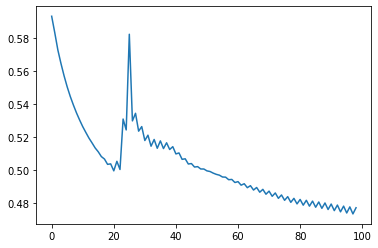

In [91]:
import matplotlib.pyplot as plt

NN = Neural_Network(inputSize=2, hiddenSize = 5, outputSize=1, lr=0.0025, m = X_train.shape[0])
Loss=[]
for i in range(100):
    A2=NN.predict(X_train)
    Loss.append(-torch.mean(y_train * torch.log(A2) + (1-y_train) * torch.log(1-A2)))
    NN.train(X_train, y_train)

plt.plot((Loss[1:]))

In [92]:
from sklearn.metrics import accuracy_score, f1_score

proba = NN.predict(X_test)
pred = []
for i in range(X_test.shape[0]):
    if proba[i]>= 0.5:
        pred.append(1)
    else:
        pred.append(0)

print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.9333333333333333
0.9523809523809523


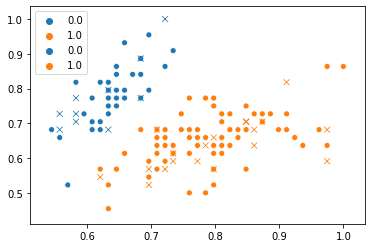

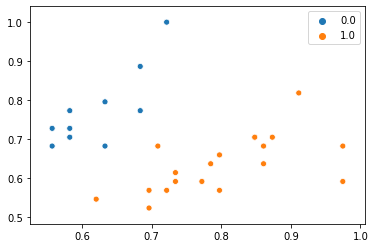

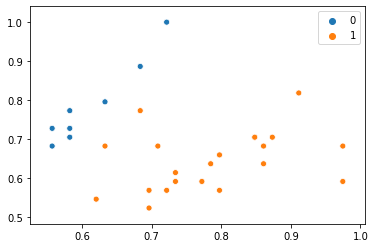

In [93]:
import seaborn as sns
figure=plt.figure(0)
sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_train.reshape(120))
figure=plt.figure(0)
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_test.reshape(30), marker='x')
figure=plt.figure(1)
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_test.reshape(30))
figure=plt.figure(2)
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=pred)